## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

In [51]:
# load in packages
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import balanced_accuracy_score
from statsmodels.stats.proportion import proportions_ztest
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
plt.rcParams['figure.figsize']=(20,6)

In [3]:
# load in the data
train_data = pd.read_csv('./training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


# assess

In [4]:
train_data.isna().any()

ID           False
Promotion    False
purchase     False
V1           False
V2           False
V3           False
V4           False
V5           False
V6           False
V7           False
dtype: bool

In [5]:
train_data.duplicated().any()

False

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84534 entries, 0 to 84533
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         84534 non-null  int64  
 1   Promotion  84534 non-null  object 
 2   purchase   84534 non-null  int64  
 3   V1         84534 non-null  int64  
 4   V2         84534 non-null  float64
 5   V3         84534 non-null  float64
 6   V4         84534 non-null  int64  
 7   V5         84534 non-null  int64  
 8   V6         84534 non-null  int64  
 9   V7         84534 non-null  int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 6.4+ MB


In [7]:
# one-hot encoding
df=pd.get_dummies(train_data,columns=['Promotion'],drop_first=True)
df.head()

,ID,purchase,V1,V2,V3,V4,V5,V6,V7,Promotion_Yes
0,1,0,2,30.443518,-1.165083,1,1,3,2,0
1,3,0,3,32.159350,-0.645617,2,3,2,2,0
2,4,0,2,30.431659,0.133583,1,1,4,2,0
3,5,0,0,26.588914,-0.212728,2,1,4,2,0
4,8,0,3,28.044332,-0.385883,1,1,2,2,1


In [8]:
df.describe()

,ID,purchase,V1,V2,V3,V4,V5,V6,V7,Promotion_Yes
count,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000
mean,62970.972413,0.012303,1.500662,29.973600,0.000190,1.679608,2.327643,2.502898,1.701694,0.501147
std,36418.440539,0.110234,0.868234,5.010626,1.000485,0.466630,0.841167,1.117349,0.457517,0.500002
min,1.000000,0.000000,0.000000,7.104007,-1.684550,1.000000,1.000000,1.000000,1.000000,0.000000
25%,31467.250000,0.000000,1.000000,26.591501,-0.905350,1.000000,2.000000,2.000000,1.000000,0.000000
50%,62827.500000,0.000000,2.000000,29.979744,-0.039572,2.000000,2.000000,3.000000,2.000000,1.000000
75%,94438.750000,0.000000,2.000000,33.344593,0.826206,2.000000,3.000000,4.000000,2.000000,1.000000
max,126184.000000,1.000000,3.000000,50.375913,1.691984,2.000000,4.000000,4.000000,2.000000,1.000000


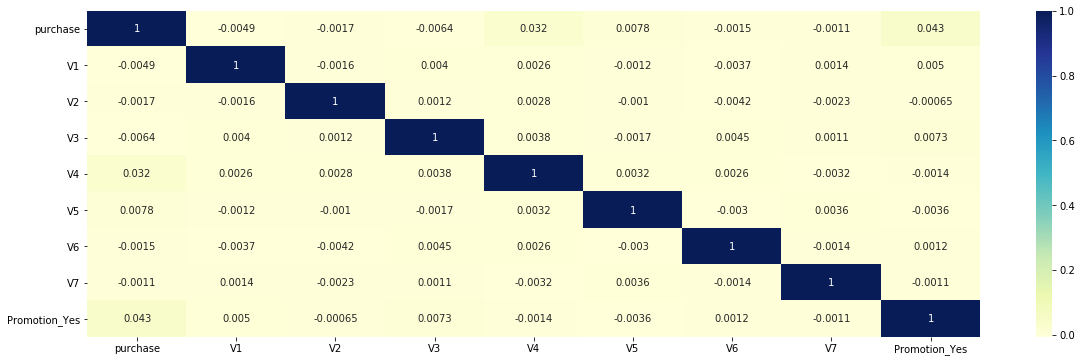

In [9]:
sb.heatmap(df.iloc[:,1:].corr(),annot=True,cmap= 'YlGnBu');

C:\Users\victo\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


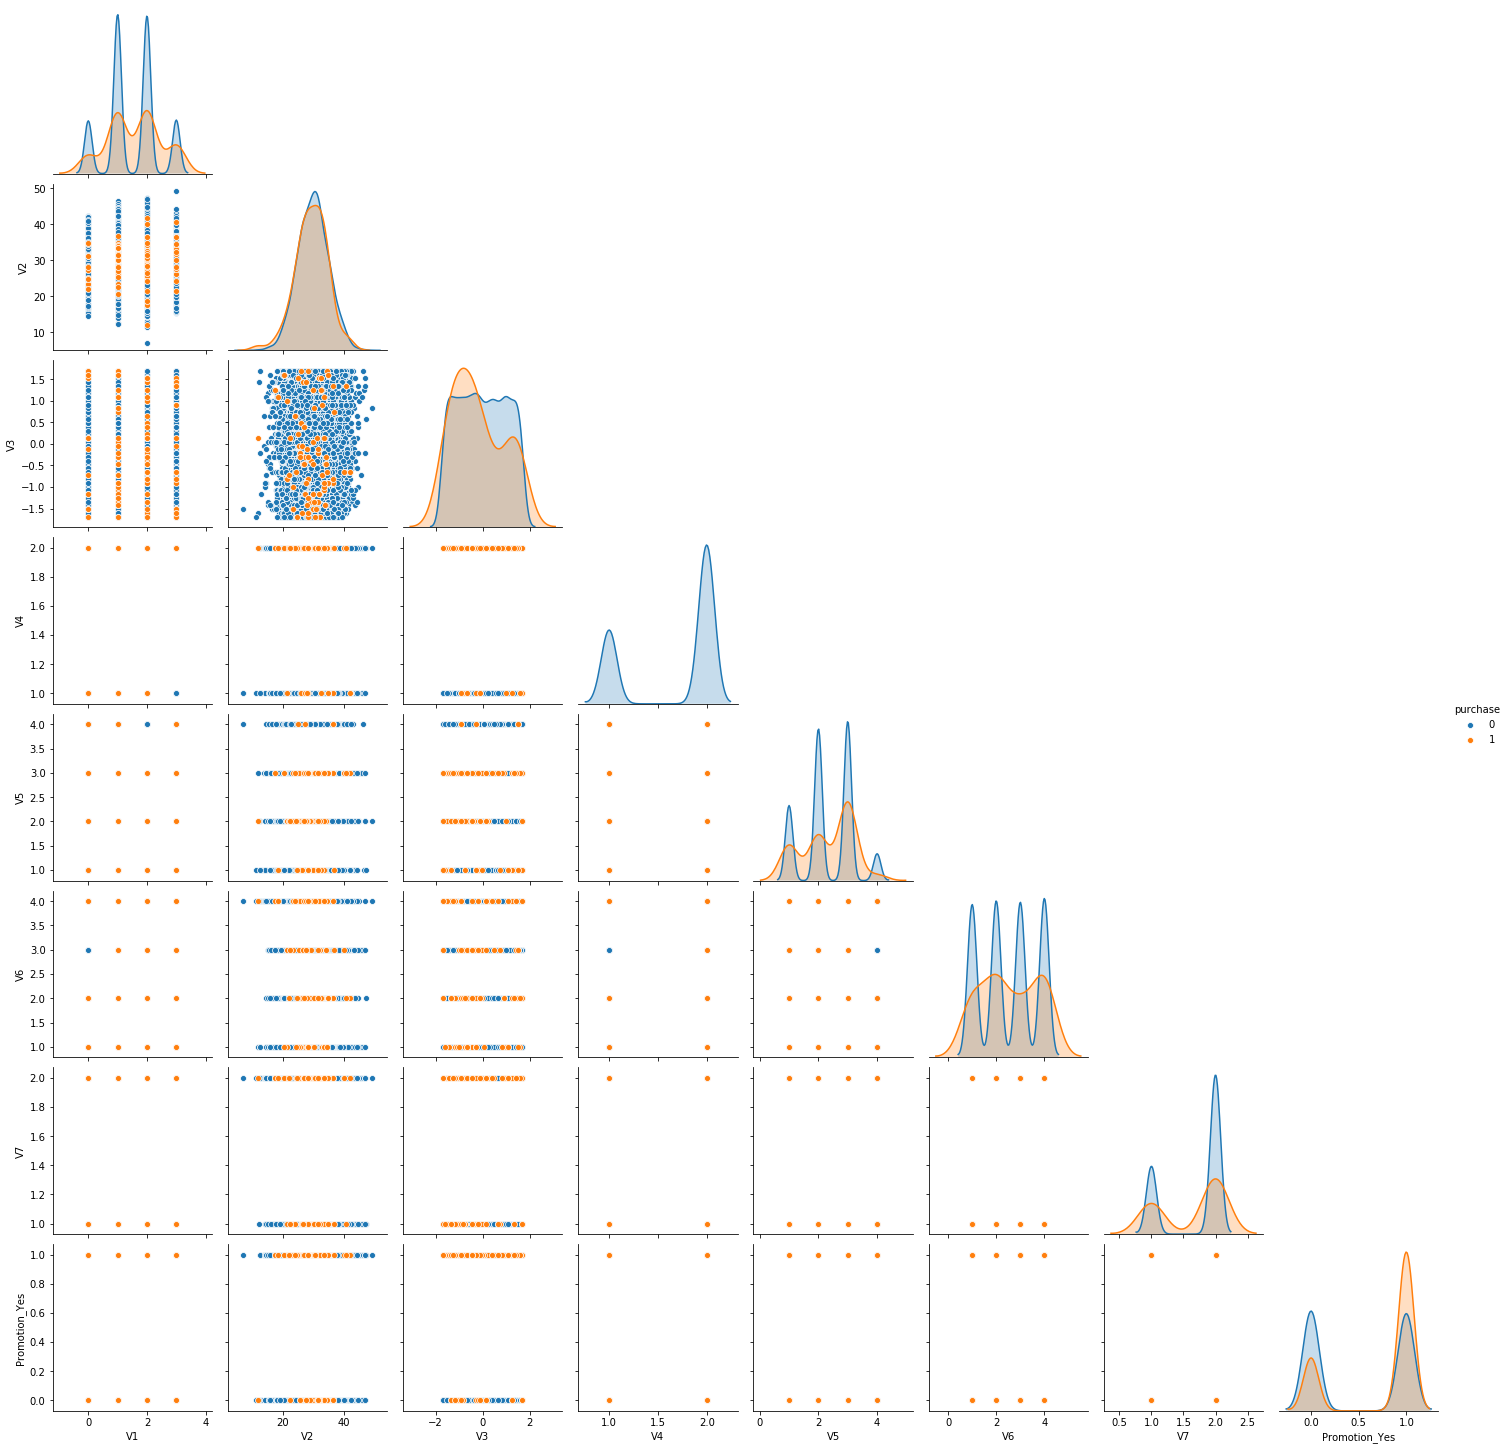

In [10]:
sb.pairplot(df.iloc[:int(df.shape[0]*.1),1:],corner=True,hue='purchase');

# exploratory & explanatory

In [11]:
# avg purchase rate by Promotion or not
avg_prom_purchase=df.groupby(['Promotion_Yes'])['purchase'].mean()
avg_prom_purchase

Promotion_Yes
0    0.007565
1    0.017019
Name: purchase, dtype: float64

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$

that is:

In [12]:
(avg_prom_purchase[1]-avg_prom_purchase[0])*100

0.9454547819772702

> this indicates about 0.95% more people purchase the product with promostion as compare to if they don't receive promotions

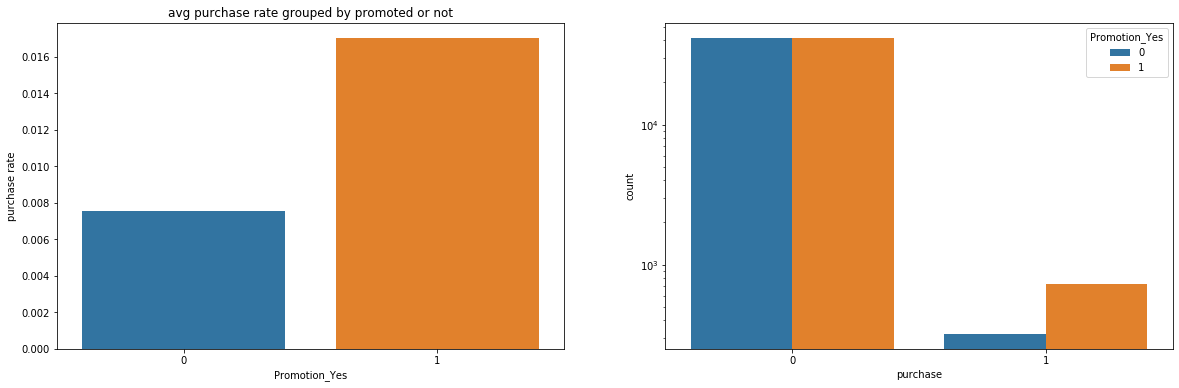

In [13]:
# avg purchase rate grouped by promoted or not plot
plt.subplot(121)
sb.barplot(avg_prom_purchase.index,avg_prom_purchase.values)
plt.title('avg purchase rate grouped by promoted or not')
plt.ylabel('purchase rate')

# purchase distribution in terms of promotion
plt.subplot(122)
sb.countplot(df['purchase'],hue=df['Promotion_Yes'])
plt.yscale('log');

> Purchase rate is obviously higher in promotion group. Number of pepople that don't make a purchase are almost the same regardless of receiving promotions or not. However, for cohort that made purchases, number of people that received promotions is significantly larger than people don't receive pormptions. This indicates promotions have some kind of effect of purchaing behaviors. We need to invesgate p-value of this A/B test to gain further evdience.

In [14]:
# p-value params
controltotal=df.query("Promotion_Yes==0").shape[0]
exptotal=df.query("Promotion_Yes==1").shape[0]
consucceed=df.query("Promotion_Yes==0")['purchase'].sum()
expsucceed=df.query("Promotion_Yes==1")['purchase'].sum()

In [15]:
# calculate p-value of this a/b test
proportions_ztest([consucceed,expsucceed],[controltotal,exptotal],alternative='smaller')

(-12.468449461599388, 5.548209627035781e-36)

> p-value is extremely small in this case (5.5e-36), which means we have a very strong evdience to reject 
$$H_{0}: P_{control}>=P_{test}$$

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$
that is:

In [16]:
(10*expsucceed-.15*exptotal)-10*consucceed

-2334.5999999999995

> Although we have statistical significant on the a/b test, but NIR suffers a negative value. This means net profit of treatment group is $2335 less than control group because control group doesn't need to bear 0.15/promotion cost. We do not have a practicial significant on this test.

In [17]:
# to break even
breakeven=(10*consucceed+.15*exptotal)/10
print("To breakeven, we need {} purchases from treatment group.".format(np.ceil(breakeven)))

To breakeven, we need 955.0 purchases from treatment group.


In [18]:
print("we need to increase treatment group purchases by {:.2f}%.".format(100*(breakeven-expsucceed)/expsucceed))

we need to increase treatment group purchases by 32.38%.


##### some other metrics correlation

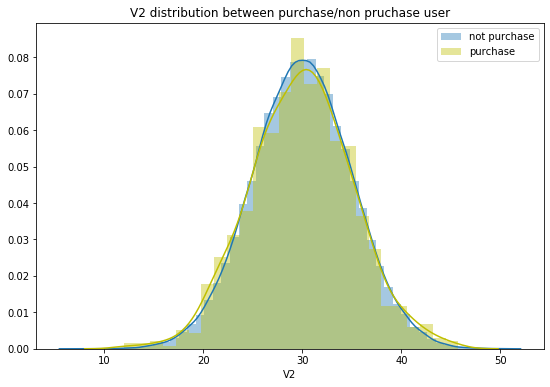

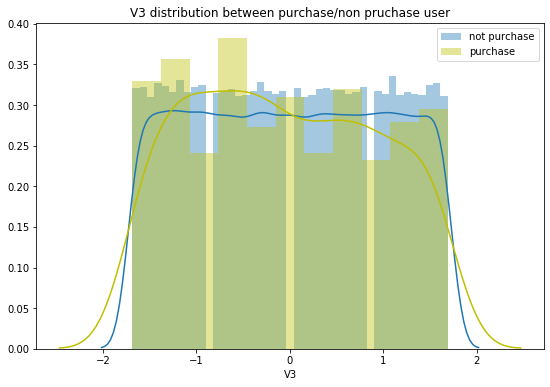

In [19]:
# V2 distribution
plt.subplot(121)
sb.distplot(df.query("purchase==0")['V2'],label='not purchase')
sb.distplot(df.query("purchase==1")['V2'],color='y',label='purchase')
plt.title('V2 distribution between purchase/non pruchase user')
plt.legend(loc=0)
plt.show()

# v3 distribution
plt.subplot(122)
sb.distplot(df.query("purchase==0")['V3'],label='not purchase')
sb.distplot(df.query("purchase==1")['V3'],color='y',label='purchase')
plt.title('V3 distribution between purchase/non pruchase user')
plt.legend(loc=0)
plt.show()

> I pick thses two because these two are continuous metrics. Here are some interesting distributions. V2 non-purchase group is almost perfectly binomial distributed while purchase group is less 'even'; Furthermore, V3 non-purchase group is almost discreted (this could also due to the bin width) and evenly distributed while purchased group is continuous andhas more ups and downs.

In [20]:
# grouped means
df.groupby(['Promotion_Yes','purchase']).mean()

ID        V1         V2        V3        V4  \
Promotion_Yes purchase                                                          
0             0         63064.059234  1.496738  29.976837 -0.007828  1.680175   
              1         67132.661442  1.435737  29.982026  0.088530  1.692790   
1             0         62821.170449  1.505559  29.972246  0.009680  1.675672   
              1         64378.528433  1.474341  29.860180 -0.121587  1.868239   

                              V5        V6        V7  
Promotion_Yes purchase                                
0             0         2.330434  2.501661  1.702014  
              1         2.357367  2.489028  1.727273  
1             0         2.323368  2.504527  1.701486  
              1         2.399445  2.486824  1.683773

> From the grouped means we can see within the same promotion group, purchase and non-pruchase cohorts are very evenly distributed across all the features except V3. This indicates they are invariant metrics or non-related features in this test except V3. V3 needs further investigation.

## mechine learning to predict customer

From two formulas we can tell to optimise INR or IRR we need to maximize purchase ratio in treatment group (increase purchase numbers in treatment group and/or decrease total number of customer in treatment group. But since the total number of customer is fixed, the only option is to increase purchase number, in another word, increase purchase ratio). 

We need to find the pattern of customers who make purchases in treatment group, then use those characteristics to predict wheather a given customer is likely to make a purchase after receiving promotions. By doing that, we are hoping to maximize our promotion effecteness.

In [21]:
df['purchase'].value_counts()/df.shape[0]

0    0.987697
1    0.012303
Name: purchase, dtype: float64

> There are only about 1.2% of target data is 1, leaves these data set is very imblanced. This would casue predicting issue on ML algorithms. We need to handle the imbalanced data first.

In [89]:
treatment_x=df.query("Promotion_Yes==1").iloc[:,2:-1]
treatment_y=df.query("Promotion_Yes==1").iloc[:,1]

In [90]:
# feature scaling
x_scaled=MinMaxScaler().fit_transform(treatment_x)

In [91]:
# split
X_train, X_test, y_train, y_test = train_test_split(x_scaled,treatment_y, random_state=42)

In [97]:
# GridSearchCV params setup
param_grid ={"base_estimator":[AdaBoostClassifier(n_estimators=100,learning_rate=1),AdaBoostClassifier(n_estimators=100,learning_rate=.5)],
      'n_estimators':[50,100]
      }

> Here we are implementing EasyEnsembleClassifier from imblanced learn library to handle imblanced data

In [98]:
# train
clf=GridSearchCV(EasyEnsembleClassifier(n_jobs=-1),param_grid ,n_jobs=-1)
clf.fit(X_train,y_train)
print(clf.best_params_)

{'base_estimator': AdaBoostClassifier(learning_rate=1, n_estimators=100), 'n_estimators': 100}


In [99]:
# predict
y_pre=clf.predict(X_test)
# socre
balanced_accuracy_score(y_test,y_pre)

0.6140066672682147

In [102]:
# transform
np.array(['Yes' if i ==1 else 'No' for i in y_pre])

array(['No', 'No', 'No', ..., 'Yes', 'No', 'No'], dtype='<U3')

In [105]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    # feature scaling
    x_scaled=MinMaxScaler().fit_transform(df)
    # predict with tuned parameters
    y_pre=clf.predict(x_scaled)
    # transform
    promotion=np.array(['Yes' if i ==1 else 'No' for i in y_pre])
    return promotion

In [106]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0183.

Your nir with this strategy is 309.40.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.018274354556892525, 309.4000000000001)